# connectLib Pipeline

## Introduction
The connectLib Pipeline filters out the background noise of an n-dimensional image and then segments the resulting image into groups of data type Cluster presented in list-form. The pipeline uses Otsu's Binarization to filter out the background noise. Next, Connected Components clusters the remaining foreground. We then remove outlier clusters using the Interquartile Range Rule. These outliers result from the filtered background which gets labeled as one large cluster. The final step is to coregister our clusters with the raw image. This is a consequence from the PLOS Pipeline (see PLOS_Pipeline_Revised.md) which degrades the original clusters.

## Simulation Data

### Easy Simulation:
Our simulated data will be a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% noise, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~.2 microns ^3, or about 27 voxels (assuming the synthetic data here and the real world data have identical resolutions). We will differeniate the background from the foreground in this simulation by assigning intensity values. Background pixels will be assigned a value from 0-10,000; foreground points will be given a value of 60,000. After the data goes through the pipeLine, I will gauge performance based on the following:

1. average volume of synapses (should be about 27 voxels) 
2. volumetric density of data (should be about 2% of the data)

We believe our pipeline will yield perfect results on this simulated data. This is because the main filtering from Otsu's Binarization requires the distribution of pixel values to be bimodal. That is, there is a clear differentiation between background and foreground. 


### Easy Simulation Code

In [23]:
import sys
sys.path.insert(0,'../code/functions/')
from random import randrange as rand
from skimage.measure import label
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

randIm = generateTestVolume()
foreground = randIm[0]
combinedIm = randIm[1]

**What We Expect Our Simulation Data Will Look Like:**
The above code should generate a 100x100x100 volume and populate it with various, non-intersectting pointsets (representing foreground synpases). When the foreground is generated, the volume will then be introduced to random background noise which will fill the rest of the volume. 

### Easy Simulation Plots

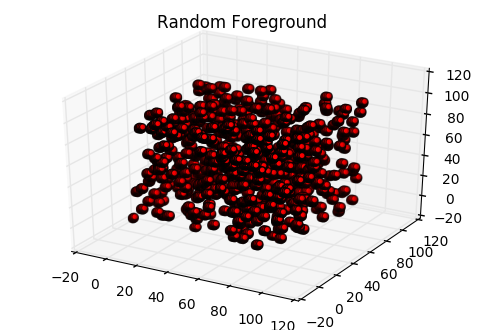

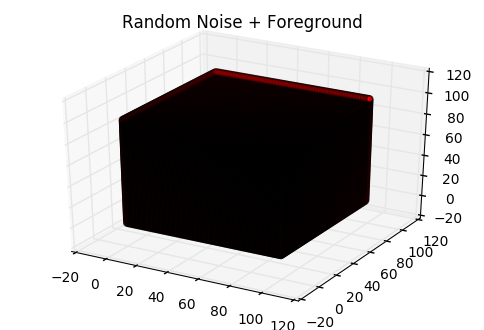

In [9]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

**Why Our Simulation is Correct:** Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

## Difficult Simulation
We will now simulate data where our algorithm will not perform well on. We will generate a 100x100x100 test volume populated with background and foreground pixels containing the same intensity. Since the distribution of pixels is now unimodal (no clear difference between background and foreground), our filtering algorithm should not work well. However, the intensity values will not appear in our matplotlib plots. Therefore, our difficult simulation will appear to be the same as the Easy Simulation, but should fail after it goes through the connectLib pipeline.

### Difficult Simulation Code and Plot

In [19]:
def generateDifficultTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = 60000
    return volume, noiseVolume

randImHard = generateDifficultTestVolume()
foregroundHard = randIm[0]
combinedImHard = randIm[1]

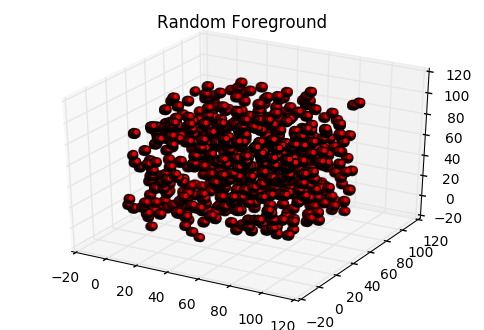

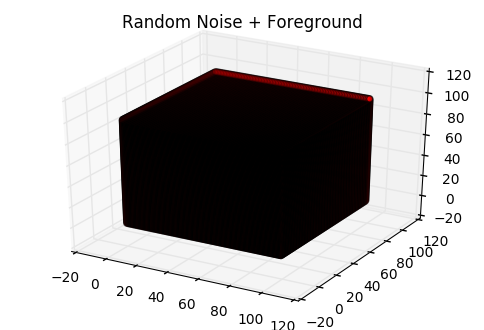

In [20]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foregroundHard.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedImHard.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

# Simulation Analysis

## Pseudocode
####################################################
###PSEUDOCODE WILL GO HERE ONCE I FIGURE OUT HOW####
####################################################

In [24]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from cluster import Cluster
import numpy as np
import cv2
import plosLib as pLib

### Step 1: Threshold the image using Otsu Binarization 
def otsuVox(argVox):
    probVox = np.nan_to_num(argVox)
    bianVox = np.zeros_like(probVox)
    for zIndex, curSlice in enumerate(probVox):
        #if the array contains all the same values
        if np.max(curSlice) == np.min(curSlice):
            #otsu thresh will fail here, leave bianVox as all 0's
            continue
        thresh = threshold_otsu(curSlice)
        bianVox[zIndex] = curSlice > thresh
    return bianVox

### Step 2: Cluster foreground using Connected Components
def connectedComponents(voxel):
    labelMap = label(voxel)
    clusterList = []
    #plus 1 since max label should be included
    for uniqueLabel in range(0, np.max(labelMap)+1):
        memberList = [list(elem) for elem in zip(*np.where(labelMap == uniqueLabel))]
        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
    return clusterList

### Step 3: Remove outlier clusters using IRQ Rule
def thresholdByVolumePercentile(clusterList):
    #putting the plosPipeline clusters volumes in a list
    plosClusterVolList =[]
    for cluster in (range(len(clusterList))):
        plosClusterVolList.append(clusterList[cluster].getVolume())

    #finding the upper outlier fence
    Q3 = np.percentile(plosClusterVolList, 75)
    Q1 = np.percentile(plosClusterVolList, 25)
    IQR = Q3 - Q1
    upperThreshFence = Q3 + 1.5*IQR
    lowerThreshFence = Q1 - 1.5*IQR

    #filtering out the background cluster
    upperThreshClusterList = []
    for cluster in (range(len(clusterList))):
        if clusterList[cluster].getVolume() < upperThreshFence and clusterList[cluster].getVolume() > lowerThreshFence:
            upperThreshClusterList.append(clusterList[cluster])

    return upperThreshClusterList

### Step 4: Coregister clusters with raw data.
def clusterCoregister(plosClusterList, rawClusterList):
    #creating a list of all the member indices of the plos cluster list
    plosClusterMemberList = []
    for cluster in range(len(plosClusterList)):
        plosClusterMemberList.extend(plosClusterList[cluster].members)

    #creating a list of all the clusters without any decay
    finalClusterList =[]
    for rawCluster in range(len(rawClusterList)):
        for index in range(len(plosClusterMemberList)):
            if ((plosClusterMemberList[index] in rawClusterList[rawCluster].members) and (not(rawClusterList[rawCluster] in finalClusterList))):
                finalClusterList.append(rawClusterList[rawCluster])

    return finalClusterList

########## Complete Pipeline ##########
def completePipeline(image):
    #Plos Pipeline Results
    plosOut = pLib.pipeline(image)
    #Otsu's Binarization Thresholding
    bianOut = otsuVox(plosOut)
    #Connected Components
    connectList = connectedComponents(bianOut)
    #Remove outlier clusters
    threshClusterList = thresholdByVolumePercentile(connectList)
    #finding the clusters without plosPipeline - lists the entire clusters
    bianRawOut = otsuVox(combinedIm)
    clusterRawList = connectedComponents(bianRawOut)
    #coregistering with raw data
    clusters = clusterCoregister(threshClusterList, clusterRawList)
    return clusters

## Easy Simulation Analysis
**What We Expect**
As previously mentioned, we believe the pipeline will work very well on the easy simulation (See Simulation Data: Easy Simulation for explanation).

**Generate Easy Simulation Data:** See Simulation Data Above.

### Pipeline Run on Easy Data

In [25]:
completeClusterMemberList = completePipeline(combinedIm)

### Easy Simulation Results 

In [59]:
### Get Cluster Volumes
def getClusterVolumes(clusterList):
    completeClusterVolumes = []
    for cluster in clusterList:
        completeClusterVolumes.append(cluster.getVolume())
    return completeClusterVolumes

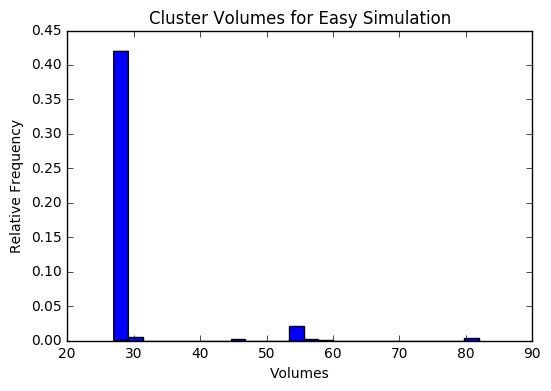

In [61]:
import mouseVis as mv

#plotting results
completeClusterVolumes = getClusterVolumes(completeClusterMemberList)
mv.generateHist(completeClusterVolumes, title = 'Cluster Volumes for Easy Simulation', bins = 25, xaxis = 'Volumes', yaxis = 'Relative Frequency')


### Performance Metrics:
We will be judging our algorithm's performance through two metrics: **average cluster volume** and **cluster density per volume**. This is based off of the 2 parameters we used to generate the test volume (see Simulation Data: Easy Simulation).

If our algorithm was successful, the average volume of detected synapse clusters should be equal to the average volume of the total foreground clusters that we generated. That is, our pipeline labeled synapses into correctly sized clusters (27 voxels). 

Cluster density basically returns how many clusters were detected given a certain volume size. This is to show how many of the synapse clusters our algorithm was actually able to label. If the algorithm performs correctly, the relative number of synapses clusters per volume should equal around 2% (the volumetric density of synapses we generated in the test volume). 

In [2]:
#test stats

# get actual cluster volumes from foreground (for 'Expected' values)
def getForegroundClusterVols(foreground):
    foregroundClusterList = cLib.connectedComponents(foreground)
    del foregroundClusterList[0] #background cluster
    foregroundClusterVols = []
    for cluster in foregroundClusterList:
        foregroundClusterVols.append(cluster.getVolume())
    return foregroundClusterVols
       
def getAverageMetric(coClusterVols, foreClusterVols):
    #no clusters found
    if (len(coClusterVols)==0):
        avgClusterVol = 0
    else:
        #average volume of detected clusters
        avgClusterVol = np.mean(coClusterVols)
    #average volume of total foreground clusters
    avgActualVol = np.mean(foreClusterVols)
    print 'Easy Simulation: Average Volume'
    print "\tExpected: " + str(avgActualVol) + '\tActual: ' + str(avgClusterVol)

def getDensityMetric(coClusterVols, foreClusterVols):
    #no clusters found
    if (len(coClusterVols)==0):
        coClusterVols.append(0)
    print 'Easy Simulation: Cluster Density of Data By Volume'
    print "\tExpected: " + str(np.sum(foreClusterVols)/(100*100*100.0)) + '\tActual: ' + str(np.sum(coClusterVols)/(100*100*100.0))

### Quantify Performance for Easy Simulation

In [63]:
foregroundClusterVols = getForegroundClusterVols(foreground)
getAverageMetric(completeClusterVolumes, foregroundClusterVols)
getDensityMetric(completeClusterVolumes, foregroundClusterVols)

Easy Simulation: Average Volume
	Expected: 29.0231404959	Actual: 29.2648083624
Easy Simulation: Cluster Density of Data By Volume
	Expected: 0.017559	Actual: 0.016798


As shown above, our connectLib pipeline worked extremely well on the easy simulation. The small difference between the actual and expected values come from the generated synapse point sets. Foreground synapses can potentially be adjacent to each other in the test volume. Connected Components will label the multiple, connected synapses as one cluster, which explains the cluster volumes at roughly 56 (2 synapses) and 81 (3 synapses) [See Histogram in Easy Simulation Results]. 

## Difficult Simulation Analysis
**What We Expect:** Since Otsu's Binarization depends on a bimodal distribution of pixel intensities, the background should not get thresholded for the difficult simulation. Furthermore, since all the pixels are identical in terms of intensity, connectedComponents should label the entire volume as just one cluster.

**Generate Difficult Simulation Data:** See Simulate Data: Difficult Simulation.


### Pipeline Run on Difficult Data:

In [33]:
completeClusterMemberListHard = completePipeline(combinedImHard)
print len(completeClusterMemberListHard)

[]


### Difficult Simulation Results:

In [67]:
#Plos Pipeline Results
plosOut = pLib.pipeline(combinedImHard)
#Otsu's Binarization Thresholding
bianOut = otsuVox(plosOut)
#Connected Components
connectList = connectedComponents(bianOut)
#get total volume for hard simulation clusters
totalClusterHard = []
for cluster in connectList:
    totalClusterHard.append(cluster.getVolume())
#get coregistered (complete) cluster volumes
completeClusterVolumesHard = getClusterVolumes(completeClusterMemberListHard)

print 'Number of Clusters: ' + str(len(totalClusterHard))
print 'Cluster Volume: ' + str(totalClusterHard[0])

print 'Coregistered Clusters: ' + str(len(completeClusterMemberListHard))

Number of Clusters: 1
Cluster Volume: 1000000
Coregistered Clusters: 0


### Performance Metrics
See Easy Simulation Analysis: Performance Metrics.

### Quantify Performance for Difficult Simulation

In [68]:
foregroundClusterVolsHard = getForegroundClusterVols(foregroundHard)
getAverageMetric(completeClusterVolumesHard, foregroundClusterVolsHard)
getDensityMetric(completeClusterVolumesHard, foregroundClusterVolsHard)

Easy Simulation: Average Volume
	Expected: 28.4733441034	Actual: 0
Easy Simulation: Cluster Density of Data By Volume
	Expected: 0.017625	Actual: 0.0


As predicted, the foreground and background was combined into one cluster through the connectLib Pipeline (see Results). This large cluster does not coregister with any of the original foreground clusters. Clearly, our pipeline performed very poorly on the difficult simulation as zero clusters were actually detected. This ultimately proves our earlier thesis that the connectLib pipeline is dependent on the foreground and background voxels having significantly different intensities.

## Summary of Simulation Analysis

Our difficult and easy simulation data demonstrates how our connectLib pipeline is dependent on how different the background and foreground voxel intensity values are. When the background and foreground are not distinguishable, the connectLib cannot threshold and filter out the background clusters, thus creating one large cluster combining all the voxels in the volume. Thus, essentially no synpases (clusters) can be detected correctly. On the other hand, if the foreground voxels are very distinguishable from the background noise (easy simulation), our connectLib pipeline works extremely well. For the easy simulations, 100% of the background noise was filtered out and almost all of the foreground point sets (representing synapses) were clustered correctly. The only errors were from adjacent 'synapses' that were clustered together. 